# PA2: Implementation of bagging and boosting using the decision tree in PA1

In [ ]:
# decision_tree.py
# ---------
# Licensing Information:  You are free to use or extend these projects for
# personal and educational purposes provided that (1) you do not distribute
# or publish solutions, (2) you retain this notice, and (3) you provide clear
# attribution to UT Dallas, including a link to http://cs.utdallas.edu.
#
# This file is part of Programming Assignment 1 for CS6375: Machine Learning.
# Gautam Kunapuli (gautam.kunapuli@utdallas.edu)
# Sriraam Natarajan (sriraam.natarajan@utdallas.edu),
#
#
# INSTRUCTIONS:
# ------------
# 1. This file contains a skeleton for implementing the ID3 algorithm for
# Decision Trees. Insert your code into the various functions that have the
# comment "INSERT YOUR CODE HERE".
#
# 2. Do NOT modify the classes or functions that have the comment "DO NOT
# MODIFY THIS FUNCTION".
#
# 3. Do not modify the function headers for ANY of the functions.
#
# 4. You may add any other helper functions you feel you may need to print,
# visualize, test, or save the data and results. However, you MAY NOT utilize
# the package scikit-learn OR ANY OTHER machine learning package in THIS file.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import preprocessing
import graphviz
import random
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

def partition(x):
    """
    Partition the column vector x into subsets indexed by its unique values (v1, ... vk)

    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values in the vector z.
    """

    # INSERT YOUR CODE HERE
    unique_values = np.unique(x)

    d = {k: [] for k in unique_values}

    for idx, val in enumerate(x):
        d[val].append(idx)

    return d
    # raise Exception('Function not yet implemented!')

def partitionBoost(x):
    """
    Partition the column vector x into subsets indexed by its unique values (v1, ... vk)

    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values in the vector z.
    """

    # INSERT YOUR CODE HERE
    unique_values = np.unique(x)

    d = {k: [] for k in unique_values}

    for idx, val in enumerate(x):
        d[val].append(idx)

    return d
    # raise Exception('Function not yet implemented!')

def entropy(y):
    """
    Compute the entropy of a vector y by considering the counts of the unique values (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """

    # INSERT YOUR CODE HERE
    unique_values = partition(y)
    number_of_samples = len(y)
    hy = 0
    for elem in unique_values.keys():
        p_elem = (float) (len(unique_values[elem]) / number_of_samples)
        log_p_elem = np.log2(p_elem)
        hy += -(p_elem * log_p_elem)
    return hy
    # raise Exception('Function not yet implemented!')

def entropyBoost(y, weights = None):
    """
    Compute the entropy of a vector y by considering the counts of the unique values (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """

    # INSERT YOUR CODE HERE
    unique_values = partitionBoost(y)
    number_of_samples = len(y)
    hy = 0
    for elem in unique_values.keys():
        prob = 0
        for row in unique_values[elem]:
            prob += weights[row]

        log_p_elem = np.log2(prob)
        hy += -(prob * log_p_elem)
    return hy
    # raise Exception('Function not yet implemented!')


def mutual_information(x, y):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """

    # INSERT YOUR CODE HERE
    hy = entropy(y)
    unique_values_of_x = partition(x)
    number_of_samples = len(x)
    hyx = 0
    for elem in unique_values_of_x.keys():
        p_x_elem = (float) (len(unique_values_of_x[elem]) / number_of_samples)
        y_new = [y[i] for i in unique_values_of_x[elem]]
        hyx_elem = entropy(y_new)
        hyx += (p_x_elem * hyx_elem)
    return (hy - hyx)
    # raise Exception('Function not yet implemented!')

def mutual_informationBoost(x, y, weights):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """

    # INSERT YOUR CODE HERE
    hy = entropyBoost(y, weights)
    unique_values_of_x = partitionBoost(x)
    number_of_samples = len(x)
    hyx = 0
    for elem in unique_values_of_x.keys():
        p_x_elem = 0
        for row in unique_values_of_x[elem]:
            p_x_elem += weights[row]

        y_new = [y[i] for i in unique_values_of_x[elem]]
        weights_new = [weights[i] for i in unique_values_of_x[elem]] 

        hyx_elem = entropyBoost(y_new, weights_new)
        hyx += (p_x_elem * hyx_elem)
    return (hy - hyx)
    # raise Exception('Function not yet implemented!')
    
def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. This is a recursive algorithm that depends on three termination conditions
        1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
        2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
        3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values of that attribute before the next recursive call to ID3.

    The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has
    to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1
    (taking values a, b, c) and x2 (taking values d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values:
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

    The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2)
    indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

    Returns a decision tree represented as a nested dictionary, for example
    {(4, 1, False):
        {(0, 1, False):
            {(1, 1, False): 1,
             (1, 1, True): 0},
         (0, 1, True):
            {(1, 1, False): 0,
             (1, 1, True): 1}},
     (4, 1, True): 1}
    """

    # INSERT YOUR CODE HERE. NOTE: THIS IS A RECURSIVE FUNCTION.
    dtree = {}
    #print(x.shape)
    if attribute_value_pairs is None:
        attribute_value_pairs = []
        for idx in range (x.shape[1]):
            for val in np.unique(np.array([item[idx] for item in x])):
                attribute_value_pairs.append((idx, val))

    attribute_value_pairs = np.array(attribute_value_pairs)

    # check for pure splits
    unique_values_of_y, count_y = np.unique(y, return_counts=True)
    if len(unique_values_of_y) == 1:
        return unique_values_of_y[0]

    if len(attribute_value_pairs) == 0 or depth == max_depth:
        return unique_values_of_y[np.argmax(count_y)]

    info_gain = []

    for feat, val in attribute_value_pairs:
        info_gain.append(mutual_information(np.array((x[:, feat] == val).astype(int)), y))

    info_gain = np.array(info_gain)
    (feat, val) = attribute_value_pairs[np.argmax(info_gain)]

    partitions = partition(np.array((x[:, feat] == val).astype(int)))

    attribute_value_pairs = np.delete(attribute_value_pairs, np.argmax(info_gain), 0)

    for value, indices in partitions.items():
        x_new = x.take(np.array(indices), axis=0)
        y_new = y.take(np.array(indices), axis=0)
        output = bool(value)

        dtree[(feat, val, output)] = id3(x_new, y_new, attribute_value_pairs=attribute_value_pairs, depth=depth+1, max_depth=max_depth)

    return dtree
    # raise Exception('Function not yet implemented!')

def id3_boosting(x, y, attribute_value_pairs=None, depth=0, max_depth=5, weights= None):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. This is a recursive algorithm that depends on three termination conditions
        1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
        2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
        3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values of that attribute before the next recursive call to ID3.

    The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has
    to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1
    (taking values a, b, c) and x2 (taking values d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values:
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

    The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2)
    indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

    Returns a decision tree represented as a nested dictionary, for example
    {(4, 1, False):
        {(0, 1, False):
            {(1, 1, False): 1,
             (1, 1, True): 0},
         (0, 1, True):
            {(1, 1, False): 0,
             (1, 1, True): 1}},
     (4, 1, True): 1}
    """

    # INSERT YOUR CODE HERE. NOTE: THIS IS A RECURSIVE FUNCTION.
    dtree = {}
    #print(x.shape)
    if attribute_value_pairs is None:
        attribute_value_pairs = []
        for idx in range (x.shape[1]):
            for val in np.unique(np.array([item[idx] for item in x])):
                attribute_value_pairs.append((idx, val))

    attribute_value_pairs = np.array(attribute_value_pairs)

    # check for pure splits
    unique_values_of_y, count_y = np.unique(y, return_counts=True)
    if len(unique_values_of_y) == 1:
        return unique_values_of_y[0]

    if len(attribute_value_pairs) == 0 or depth == max_depth:
        return unique_values_of_y[np.argmax(count_y)]

    info_gain = []

    for feat, val in attribute_value_pairs:
        info_gain.append(mutual_informationBoost(np.array((x[:, feat] == val).astype(int)), y, weights))

    info_gain = np.array(info_gain)
    (feat, val) = attribute_value_pairs[np.argmax(info_gain)]

    partitions = partitionBoost(np.array((x[:, feat] == val).astype(int)))

    attribute_value_pairs = np.delete(attribute_value_pairs, np.argmax(info_gain), 0)

    for value, indices in partitions.items():
        x_new = x.take(np.array(indices), axis=0)
        y_new = y.take(np.array(indices), axis=0)
        w_new = weights.take(np.array(indices), axis=0)
        output = bool(value)

        dtree[(feat, val, output)] = id3_boosting(x_new, y_new, attribute_value_pairs=attribute_value_pairs, depth=depth+1, max_depth=max_depth, weights = w_new)

    return dtree
    # raise Exception('Function not yet implemented!')

def predict_example(x, tree):
    """
    Predicts the classification label for a single example x using tree by recursively descending the tree until
    a label/leaf node is reached.

    Returns the predicted label of x according to tree
    """

    # INSERT YOUR CODE HERE. NOTE: THIS IS A RECURSIVE FUNCTION.
    for decision_node, child_tree in tree.items():
        idx = decision_node[0]
        val = decision_node[1]
        decision = decision_node[2]

        if decision == (x[idx] == val):
            if type(child_tree) is not dict:
                class_label = child_tree
            else:
                class_label = predict_example(x, child_tree)

            return class_label
    # raise Exception('Function not yet implemented!')


def compute_error(y_true, y_pred):
    """
    Computes the average error between the true labels (y_true) and the predicted labels (y_pred)

    Returns the error = (1/n) * sum(y_true != y_pred)
    """

    # INSERT YOUR CODE HERE
    return np.sum(np.absolute(y_true - y_pred)) / len(y_true)
    # raise Exception('Function not yet implemented!')


def visualize(tree, depth=0):
    """
    Pretty prints (kinda ugly, but hey, it's better than nothing) the decision tree to the console. Use print(tree) to
    print the raw nested dictionary representation.
    DO NOT MODIFY THIS FUNCTION!
    """

    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1}]'.format(split_criterion[0], split_criterion[1]))

        # Print the children
        if type(sub_trees) is dict:
            visualize(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))


def confusion_matrix(y, y_pred, fig):
    confusion_matrix = np.zeros((2, 2))
    rows = ["Actual Positive", "Actual Negative"]
    cols = ("Classifier Positive", "Classifier Negative")
    for i, j in zip(y, y_pred):
        confusion_matrix[i][j] += 1
    temp = np.flip(confusion_matrix, 0)
    confusion_matrix = np.flip(temp, 1)
    fig.subplots_adjust(left=0.3,top=0.8, wspace=1)
    ax = plt.subplot2grid((1,1), (0,0), colspan=2, rowspan=2)
    ax.table(cellText=confusion_matrix.tolist(),
          rowLabels=rows,
          colLabels=cols, loc="upper center")
    ax.axis("off")


def confusion_matrix_multiclass(y, y_pred, classes, fig):
    confusion_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))))
    rows = []
    columns = []
    for cl in classes.tolist():
        rows.append("Actual " + str(cl))
        columns.append("Predicted " + str(cl))

    for i, j in zip(y, y_pred):
        confusion_matrix[i][j] += 1
    # temp = np.flip(confusion_matrix, 0)
    # confusion_matrix = np.flip(temp, 1)
    fig.subplots_adjust(left=0.3,top=0.8, wspace=2)
    ax = plt.subplot2grid((1,1), (0,0), colspan=2, rowspan=2)
    table = ax.table(cellText=confusion_matrix.tolist(),
          rowLabels=rows,
          colLabels=columns, loc="upper center")
    table.set_fontsize(14)
    table.scale(1, 2)
    ax.axis("off")

def BootStrap(x, y, sample_size):
    '''
    This functions creates bootstrap sample out of input data.
    Parameters
        input:
             x => training data
             y => labels
             sample_size => number of rows to sample
        output:
             X => training data
             Y => labels
    '''
    X = np.zeros(x.shape)
    Y = np.zeros(y.shape)
    for i in range(0, sample_size):
        index = random.randint(0, sample_size-1)
        X[i] = x[index]
        Y[i] = y[index]

    return X.astype(int), Y.astype(int)

def bagging(x, y , max_depth, num_trees):
    '''
    input:
        x => training data
        y => labels
        max_depth => max_depth of each tree
        num_trees => number of trees to be created in bagging
    output:
        Hypothesis => List of tuples. Where each tuple is pair
                      it's weight and Decision tree. 

    '''
    Hypothesis = []
    total_rows = x.shape[0]
    for i in range(0, num_trees):
        x , y = BootStrap(x, y, total_rows)
        tree = id3(x, y, max_depth = max_depth)
        Hypothesis.append((1,tree))
    return Hypothesis


def boosting(x, y, max_depth, num_stumps):
    total_samples = x.shape[0]
    D = np.ones(total_samples)
    D /= total_samples
    h_ens = []

    for i in range(num_stumps):
        tree = id3_boosting(x, y, max_depth= max_depth, weights= D)
        y_pred = [predict_example(row, tree) for row in x]
        e_t = np.dot(np.absolute(y - y_pred), D)
        alpha = 0.5*np.log((1-e_t)/e_t)
        indicator = np.absolute(y - y_pred)
        for idx, val in enumerate(D):
            if indicator[idx]:
                D[idx] *= np.exp(alpha)
            else:
                D[idx] *= np.exp(-alpha)
        D /= np.sum(D)

        #print("row: ", i, "Weights", np.sum(D))
        #print("Iteration: ", i,"Alph: ", alpha, "Error: ", e_t)
        h_ens.append((alpha, tree))

    return h_ens

def predict_example_ensembel(x, h_ens, flag = None):
    
    if flag:
        temp = [ int(predict_example(x, tree[1])*tree[0]) for tree in h_ens]
        y_pred = max(set(temp), key=temp.count)
        return y_pred
    
    else:
        count  = 0
        for tree in h_ens:
            count += predict_example(x, tree[1])*tree[0]
        
        if (count >= 0.5):
            return 1
        else:
            return 0

PART A - Four Combination of bagging size 10, 20 and tree depth 3,5
Number of Bags: 10 , Depth of Decision Tree: 3
Testing error=3.58%
Number of Bags: 10 , Depth of Decision Tree: 5
Testing error=0.21%
Number of Bags: 20 , Depth of Decision Tree: 3
Testing error=5.40%
Number of Bags: 20 , Depth of Decision Tree: 5
Testing error=0.13%


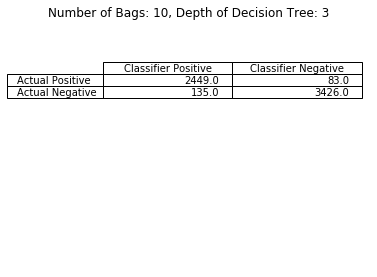

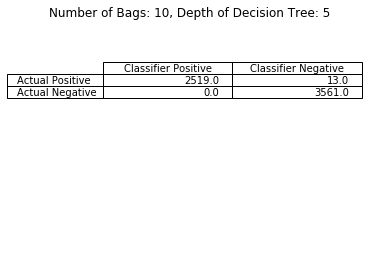

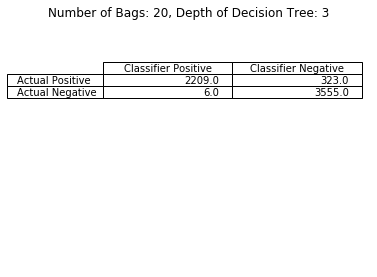

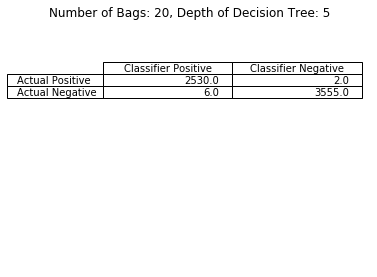

PART B - Four Combination of Boosting Number of stumps of size 10, 20 and tree depth 1,2
Number of Stumps: 20 , Depth of Decision Tree: 1
Testing error=9.49%
Number of Stumps: 20 , Depth of Decision Tree: 2
Testing error=55.70%
Number of Stumps: 40 , Depth of Decision Tree: 1
Testing error=9.49%
Number of Stumps: 40 , Depth of Decision Tree: 2
Testing error=55.70%


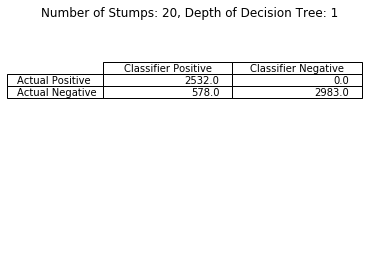

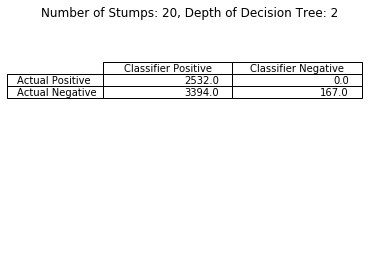

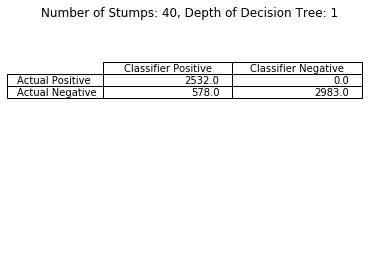

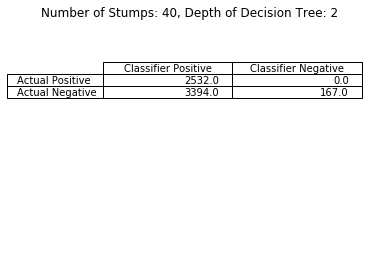

PART C - Sklearn bagging
Number of Stumps: 10 , Depth of Decision Tree: 3
Testing error=5.40%
Number of Stumps: 10 , Depth of Decision Tree: 5
Testing error=1.67%
Number of Stumps: 20 , Depth of Decision Tree: 3
Testing error=5.40%
Number of Stumps: 20 , Depth of Decision Tree: 5
Testing error=1.00%
PART C - Sklearn boosting
Number of Stumps: 20 , Depth of Decision Tree: 1
Testing error=0.10%
Number of Stumps: 20 , Depth of Decision Tree: 2
Testing error=0.00%
Number of Stumps: 40 , Depth of Decision Tree: 1
Testing error=0.00%
Number of Stumps: 40 , Depth of Decision Tree: 2
Testing error=0.00%


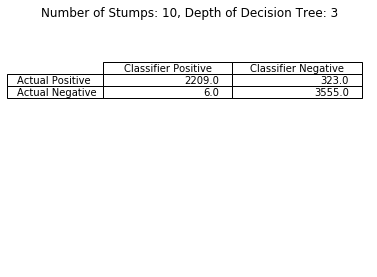

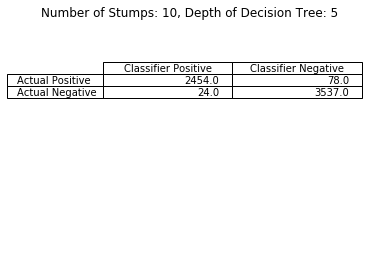

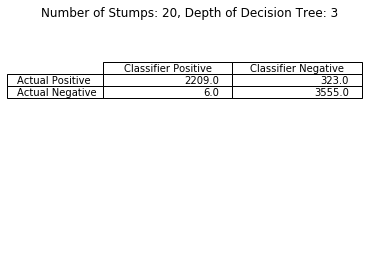

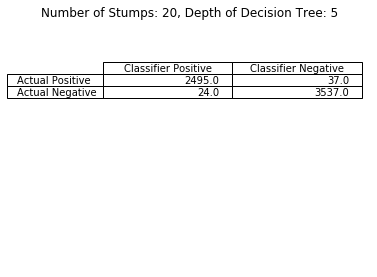

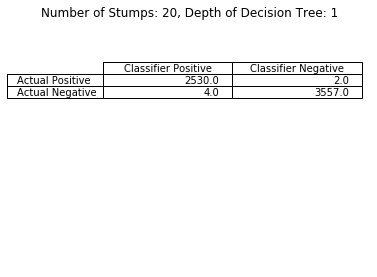

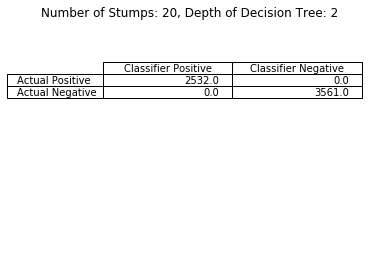

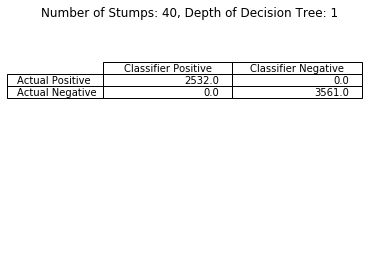

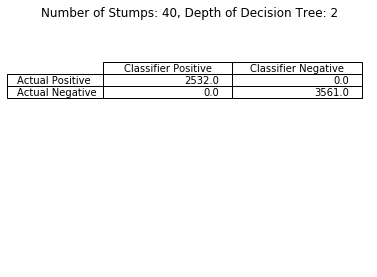

In [12]:
if __name__ == '__main__':
    M = np.genfromtxt('mushroom/mushroom.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytrn = M[:, 0]
    Xtrn = M[:, 1:]
    
    tst_Error_Array = []
    depth_Array = []
    tr_error_array=[]
    M = np.genfromtxt('mushroom/mushroom.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytst = M[:, 0]
    Xtst = M[:, 1:]
    count = 0
    #print(ytrn.shape)
    #print(Xtrn.shape)

    print('======================================================================')
    print('PART A - Four Combination of bagging size 10, 20 and tree depth 3,5')
    print('======================================================================')
    for i in [10, 20]:
        for j in [3, 5]:
            print("Number of Bags:", i, ", Depth of Decision Tree:", j)
            h_ens = bagging(Xtrn, ytrn, max_depth=j, num_trees = i)
            y_pred = [predict_example_ensembel(x, h_ens, 1) for x in Xtst]
            tst_err = compute_error(ytst, y_pred)
            print('Testing error={0:4.2f}%'.format(tst_err*100))
            fig1 = plt.figure(count)
            count += 1
            confusion_matrix( ytst, y_pred, fig1)
            fig1.suptitle("Number of Bags: " + str(i) + ", Depth of Decision Tree: " + str(j))
    plt.show()

    print('==========================================================================================')
    print('PART B - Four Combination of Boosting Number of stumps of size 10, 20 and tree depth 1,2')
    print('===========================================================================================')
    for i in [20, 40]:
        for j in [1, 2]:
            print("Number of Stumps:", i, ", Depth of Decision Tree:", j)
            h_ens = boosting(Xtrn, ytrn, max_depth=j, num_stumps = i)
            y_pred = [predict_example_ensembel(x, h_ens, 0) for x in Xtst]
            tst_err = compute_error(ytst, y_pred)
            print('Testing error={0:4.2f}%'.format(tst_err*100))
            fig1 = plt.figure(count)
            count += 1
            confusion_matrix( ytst, y_pred, fig1)
            fig1.suptitle("Number of Stumps: " + str(i) + ", Depth of Decision Tree: " + str(j))
    plt.show()

    print('=======================================================================')
    print('PART C - Sklearn bagging')
    print('=======================================================================')
    #Bagging
    #print("Bagging")
    for i in [10, 20]:
        for j in [3, 5]:
            print("Number of Stumps:", i, ", Depth of Decision Tree:", j)
            DT = DecisionTreeClassifier(max_depth= j, criterion ="entropy")
            model = BaggingClassifier(base_estimator=DT, n_estimators=i)
            model.fit(Xtrn, ytrn)
            y_pred = model.predict(Xtst)
            tst_err = compute_error(ytst, y_pred)
            print('Testing error={0:4.2f}%'.format(tst_err*100))
            fig1 = plt.figure(count)
            count += 1
            confusion_matrix( ytst, y_pred, fig1)
            fig1.suptitle("Number of Stumps: " + str(i) + ", Depth of Decision Tree: " + str(j))

    print('=======================================================================')
    print('PART C - Sklearn boosting')
    print('=======================================================================')
    #Boosting
    #print("Boosting")
    for i in [20, 40]:
        for j in [1, 2]:
            print("Number of Stumps:", i, ", Depth of Decision Tree:", j)
            DT = DecisionTreeClassifier(max_depth= j, criterion ="entropy")
            model = AdaBoostClassifier(base_estimator=DT, n_estimators=i)
            model.fit(Xtrn, ytrn)
            y_pred = model.predict(Xtst)
            tst_err = compute_error(ytst, y_pred)
            print('Testing error={0:4.2f}%'.format(tst_err*100))
            fig1 = plt.figure(count)
            count += 1
            confusion_matrix( ytst, y_pred, fig1)
            fig1.suptitle("Number of Stumps: " + str(i) + ", Depth of Decision Tree: " + str(j))